# Evaluate the use of the similarity code for trip clustering

In this notebook, we are going to dig deeper into the use of the similarity code for trip clustering. The original goal of the similarity code was to find and display common trips to users in a user interface. We plan to use it to automatically label common trips.

The goals seem very similar, but are they? Or should our usage patterns for this new use case be subtly different?

This notebook is intended to be run against the participant-only version of the CanBikeCO Jan 31 minipilot dataset.
If you have the older version that includes data from non-participants as well, please replace

```
all_users = esta.TimeSeries.get_uuid_list()
```

with 

```
participant_uuid_obj = list(edb.get_profile_db().find({"install_group": "participant"}, {"user_id": 1, "_id": 0}))
all_users = [u["user_id"] for u in participant_uuid_obj]
```

### First, we read the data and extract the most common purpose labels

In [1]:
import pandas as pd
import numpy as np
import geojson as gj
import sklearn.cluster as sc
import sklearn.metrics.pairwise as smp

In [2]:
import json
import copy

In [3]:
import folium
import branca.element as bre

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import seaborn as sns

In [5]:
from IPython import display
from uuid import UUID

import bson.json_util as bju
import bson.objectid as boi

In [6]:
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.analysis.modelling.tour_model.similarity as eamts

storage not configured, falling back to sample, default configuration
Connecting to database URL localhost


In [7]:
import emission.core.wrapper.entry as ecwe
import emission.core.wrapper.confirmedtrip as ecwct

### Read data and setup variables

In [8]:
all_users = esta.TimeSeries.get_uuid_list()
confirmed_trip_df_map = {}
labeled_trip_df_map = {}
expanded_trip_df_map = {}
for u in all_users:
    ts = esta.TimeSeries.get_time_series(u)
    ct_df = ts.get_data_df("analysis/confirmed_trip")
    confirmed_trip_df_map[u] = ct_df
    labeled_trip_df_map[u] = esdtq.filter_labeled_trips(ct_df)
    expanded_trip_df_map[u] = esdtq.expand_userinputs(labeled_trip_df_map[u])

In [9]:
FINAL_RADIUS = 500
FINAL_POINT_DBSCAN = sc.DBSCAN(FINAL_RADIUS, min_samples=2, metric="precomputed")
FINAL_TRIP_DBSCAN = sc.DBSCAN(FINAL_RADIUS * 2, min_samples=2, metric="precomputed")

### Standard functions (currently copied over from other notebooks; should be refactored into a python file)

In [10]:
def get_loc_df(loc_series):
    loc_df = pd.DataFrame(loc_series.apply(lambda p: p["coordinates"]).to_list(), columns=["longitude", "latitude"])
    # display.display(end_loc_df.head())
    return loc_df

In [11]:
def get_distance_matrix(loc_df):
    EARTH_RADIUS = 6371000
    radians_lat_lon = np.radians(loc_df[["latitude", "longitude"]])
    dist_matrix_meters = pd.DataFrame(smp.haversine_distances(radians_lat_lon, radians_lat_lon) * 6371000)
    return dist_matrix_meters

In [12]:
def add_loc_clusters(user_id, modeling_support_objects, trip_df):
    user_trip_df = trip_df[trip_df.user_id == user_id]
    start_distance_matrix = get_distance_matrix(get_loc_df(user_trip_df.start_loc))
    end_distance_matrix = get_distance_matrix(get_loc_df(user_trip_df.end_loc))
    start_loc_model = copy.copy(FINAL_POINT_DBSCAN).fit(start_distance_matrix)
    end_loc_model = copy.copy(FINAL_POINT_DBSCAN).fit(end_distance_matrix)
    trip_df.loc[user_trip_df.index, "start_loc_cluster"] = start_loc_model.labels_
    trip_df.loc[user_trip_df.index, "end_loc_cluster"] = end_loc_model.labels_

    curr_model_support = modeling_support_objects.get(user_id)
    if curr_model_support is None:
        modeling_support_objects[user_id] = {}
        curr_model_support = modeling_support_objects[user_id]
    curr_model_support["start_distance_matrix"] = start_distance_matrix
    curr_model_support["end_distance_matrix"] = end_distance_matrix   
    curr_model_support["start_loc_model"] = start_loc_model
    curr_model_support["end_loc_model"] = end_loc_model

    return trip_df

In [13]:
def add_trip_clusters_dbscan(user_id, trip_df):
    user_trip_df = trip_df[trip_df.user_id == user_id]
    all_combos = user_trip_df.groupby(["start_loc_cluster", "end_loc_cluster"])
    valid_combos = [p for p in all_combos.groups if p[0] != -1 and p[1] != -1]
    print(f"After validating, all_combos {len(all_combos.groups)} -> {len(valid_combos)}")
    all_combos_dict = dict(all_combos.groups)
    valid_combos_series = pd.Series(valid_combos)
    for g, idxlist in all_combos_dict.items():
        print(g, idxlist)
        match = valid_combos_series[valid_combos_series == g]
        if len(match) == 0:
            print(f"invalid combo {g} found for entries {idxlist}, trip is not in a cluster")
            trip_df.loc[idxlist, "trip_cluster_dbscan"] = -1
        else:
            print(f"valid combo {g} found for entries {idxlist}, setting trip cluster to {match.index[0]}")
            trip_df.loc[idxlist, "trip_cluster_dbscan"] = int(match.index[0])
    return trip_df

### First, we pick a participant to work with

In [14]:
n_trips_df = pd.DataFrame([[u, len(confirmed_trip_df_map[u]), len(labeled_trip_df_map[u])] for u in all_users], columns=["user_id", "all_trips", "labeled_trips"]); n_trips_df

,user_id,all_trips,labeled_trips
0,1044195f-af9e-43d4-9407-60594e5e9938,480,380
1,113aef67-400e-4e21-a29f-d04e50fc42ea,453,33
2,1d292b85-c549-409a-a10d-746e957582a0,215,208
3,5079bb93-c9cf-46d7-a643-dfc86bb05605,294,212
4,576e37c7-ab7e-4c03-add7-02486bc3f42e,237,226
5,898b1a5e-cdd4-4a0c-90e4-942fa298e456,274,264
6,8b563348-52b3-4e3e-b046-a0aaf4fcea15,66,1
7,960835ac-9d8a-421d-8b8a-bf816f8a4b92,626,618
8,c8b9fe22-86f8-449a-b64f-c18a8d20eefc,182,163
9,cb3222a7-1e72-4a92-8b7b-2c4795402497,236,22


In [15]:
median_user = n_trips_df[n_trips_df.labeled_trips == n_trips_df.labeled_trips.median()].user_id.iloc[0]; median_user

UUID('1d292b85-c549-409a-a10d-746e957582a0')

In [16]:
median_user_df = expanded_trip_df_map[median_user]

In [17]:
# add_trip_clusters_oursim(participant_df.index[0], all_expanded_df)
user_id = median_user
user_trip_df = median_user_df
user_trip_list = [ecwe.Entry({"data": ecwct.Confirmedtrip(tr), "_id": tr["_id"], "metadata": {"key": "analysis/confirmed_trip"}}) for tr in user_trip_df.to_dict("records")]
curr_sim = eamts.similarity(user_trip_list, FINAL_RADIUS)
curr_sim.bin_data()

### Step 1: filtering too short trips

This is the first step of the binning, where we have not yet determined the cutoff and deleted the bins below it. However, we *have* filtered out trips that are too short. Let's examine if this filtering makes sense to us.

In [18]:
filtered_trip_df = pd.DataFrame([e["data"] for e in curr_sim.data])
removed_trips = user_trip_df[~user_trip_df._id.isin(filtered_trip_df._id)]
removed_trips.distance

0        384.730231
3        434.038504
4        333.230154
8        401.112438
12      3709.362816
13       520.045575
16       361.384122
17       282.347618
29      1395.281290
30       359.031469
32      1123.483301
33       188.659530
35       597.671353
37       741.332228
41       816.366795
64      1355.818152
65       205.318487
67     18856.731080
68       230.650648
70       718.709280
83      6785.535867
84       831.068100
89       165.173889
97       175.483272
98       218.431141
113      220.327550
116      472.515693
119      252.892584
140      168.241488
145      229.877958
146      228.087648
149     1519.919378
157      312.377256
158      200.998037
159      248.875588
160      243.955805
161      241.290720
164      530.910192
166      422.958457
167     1681.122318
168     2147.090932
169      253.747549
172     3204.025261
173      251.003381
176      654.108057
179      557.154621
201     9578.320076
206      255.993197
207      224.726835
Name: distance, dtyp

Let's now characterise this in multiple ways.

In [19]:
removed_trips.distance.describe()

count       49.000000
mean      1332.479958
std       3067.461589
min        165.173889
25%        241.290720
50%        384.730231
75%        816.366795
max      18856.731080
Name: distance, dtype: float64

In [20]:
removed_trips.distance[removed_trips.distance > FINAL_RADIUS]; len(removed_trips.distance[removed_trips.distance > FINAL_RADIUS])

20

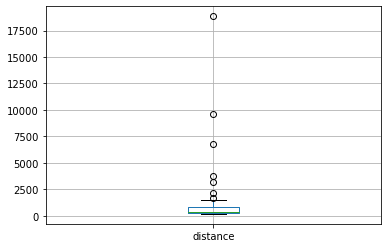

In [21]:
removed_trips.boxplot("distance")

### Filtering does not make sense

It turns out that this filtering does not make sense.

1. Even if the start and end are close to each other, the actual trip may not be very short because it may be a round trip.
2. For example, around half of the trips that are filtered actually have a distance > our filter.
3. The others may be "not a trip" aka fake trips. But those are still valuable! If the user has been labeling short trips to and from a particular location as "Not a trip", then automatically labeling those as "Not a trip" will still save the user a ton of time!

### Step 2: binning

We now bin the trips to effectively create "clusters". Let us compare these clusters against the DBSCAN clusters.

In [22]:
# Create DBSCAN clusters
modeling_support_objects = {}
add_trip_clusters_dbscan(user_id, add_loc_clusters(user_id, modeling_support_objects, user_trip_df))

After validating, all_combos 80 -> 69
(-1, -1) Int64Index([181, 182, 191, 197], dtype='int64')
invalid combo (-1, -1) found for entries Int64Index([181, 182, 191, 197], dtype='int64'), trip is not in a cluster
(-1, 0) Int64Index([28, 34, 44, 48, 72, 74, 100, 121, 183, 198], dtype='int64')
invalid combo (-1, 0) found for entries Int64Index([28, 34, 44, 48, 72, 74, 100, 121, 183, 198], dtype='int64'), trip is not in a cluster
(-1, 1) Int64Index([153, 192], dtype='int64')
invalid combo (-1, 1) found for entries Int64Index([153, 192], dtype='int64'), trip is not in a cluster
(-1, 10) Int64Index([19], dtype='int64')
invalid combo (-1, 10) found for entries Int64Index([19], dtype='int64'), trip is not in a cluster
(-1, 15) Int64Index([163], dtype='int64')
invalid combo (-1, 15) found for entries Int64Index([163], dtype='int64'), trip is not in a cluster
(0, -1) Int64Index([47, 73, 99, 131, 180, 190, 196], dtype='int64')
invalid combo (0, -1) found for entries Int64Index([47, 73, 99, 131, 180

,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode,start_loc_cluster,end_loc_cluster,trip_cluster_dbscan
0,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09,walk,meal,same_mode,0,0,0.0
1,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,train,personal_med,same_mode,0,1,1.0
2,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,skateboard,transit_transfer,bus,1,2,17.0
3,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,not_a_trip,transit_transfer,same_mode,2,2,21.0
4,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09,not_a_trip,transit_transfer,same_mode,2,2,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,DwellSegmentationTimeFilter,1.612027e+09,2021-01-30T10:10:11.271000-07:00,"{'type': 'Point', 'coordinates': [-104.9412627...",60159fde780d93a383aeaceb,1.612026e+09,2021-01-30T10:03:38.301500-07:00,"{'type': 'Point', 'coordinates': [-104.9410274...",392.969500,1661.638751,...,America/Denver,60159ff0780d93a383aead21,1d292b85-c549-409a-a10d-746e957582a0,1.612030e+09,shared_ride,work,same_mode,23,0,68.0
204,DwellSegmentationTimeFilter,1.612030e+09,2021-01-30T11:09:00.496000-07:00,"{'type': 'Point', 'coordinates': [-104.9410838...",6015adea1bab2d95b869355e,1.612030e+09,2021-01-30T11:00:38.619918-07:00,"{'type': 'Point', 'coordinates': [-104.9412627...",501.876082,1689.490782,...,America/Denver,6015ae001bab2d95b86935aa,1d292b85-c549-409a-a10d-746e957582a0,1.612034e+09,shared_ride,work,same_mode,0,21,14.0
205,DwellSegmentationTimeFilter,1.612031e+09,2021-01-30T11:27:40.596000-07:00,"{'type': 'Point', 'coordinates': [-104.9412735...",6015adeb1bab2d95b8693560,1.612030e+09,2021-01-30T11:12:00.496000-07:00,"{'type': 'Point', 'coordinates': [-104.9410838...",940.100000,1626.118529,...,America/Denver,6015ae001bab2d95b86935ab,1d292b85-c549-409a-a10d-746e957582a0,1.612034e+09,shared_ride,home,same_mode,23,0,68.0
206,DwellSegmentationTimeFilter,1.612037e+09,2021-01-30T12:59:27.149000-07:00,"{'type': 'Point', 'coordinates': [-104.9397768...",6015ca10995adf38c815560e,1.612036e+09,2021-01-30T12:47:19.349658-07:00,"{'type': 'Point', 'coordinates': [-104.9412735...",727.799341,255.993197,...,America/Denver,6015ca11995adf38c8155653,1d292b85-c549-409a-a10d-746e957582a0,1.612041e+09,walk,meal,same_mode,0,0,0.0


In [23]:
# Create oursim bin
# curr_sim.bin_data()
all_bins = curr_sim.bins
for b in all_bins:
    print(b)

[6, 19, 100, 106, 115, 120, 149]
[18, 71, 99, 105, 107, 114, 116]
[12, 26, 60, 84, 89, 143]
[15, 38, 45, 70, 98, 133]
[16, 27, 48, 50, 128]
[47, 73, 79, 113, 127]
[14, 37, 69, 97]
[138, 153, 155, 157]
[139, 154, 156, 158]
[4, 66, 86]
[17, 49, 129]
[31, 142, 147]
[34, 55, 140]
[40, 77, 109]
[65, 85, 94]
[7, 13]
[9, 82]
[23, 30]
[25, 59]
[36, 96]
[39, 76]
[46, 78]
[56, 141]
[72, 112]
[80, 90]
[101, 118]
[102, 119]
[104, 117]
[0]
[1]
[2]
[3]
[5]
[8]
[10]
[11]
[20]
[21]
[22]
[24]
[28]
[29]
[32]
[33]
[35]
[41]
[42]
[43]
[44]
[51]
[52]
[53]
[54]
[57]
[58]
[61]
[62]
[63]
[64]
[67]
[68]
[74]
[75]
[81]
[83]
[87]
[88]
[91]
[92]
[93]
[95]
[103]
[108]
[110]
[111]
[121]
[122]
[123]
[124]
[125]
[126]
[130]
[131]
[132]
[134]
[135]
[136]
[137]
[144]
[145]
[146]
[148]
[150]
[151]
[152]


Let's try to convert the bins into labels to be consistent with the sklearn clustering algorithms
**TODO: This should really go into the sim implementation**
again, to be consistent with the sklearn configuration, we use a min_sample of 2
so trips that are in a bin of length 1 are noise. the others are in a labeled cluster

In [24]:
removed_trips.index

Int64Index([  0,   3,   4,   8,  12,  13,  16,  17,  29,  30,  32,  33,  35,
             37,  41,  64,  65,  67,  68,  70,  83,  84,  89,  97,  98, 113,
            116, 119, 140, 145, 146, 149, 157, 158, 159, 160, 161, 164, 166,
            167, 168, 169, 172, 173, 176, 179, 201, 206, 207],
           dtype='int64')

In [25]:
len(removed_trips), len(filtered_trip_df), len(user_trip_df)

(49, 159, 208)

In [26]:
import itertools

In [27]:
flat_all_bins = list(itertools.chain(*all_bins)); flat_all_bins[:5]

[6, 19, 100, 106, 115]

In [28]:
len(flat_all_bins), max(flat_all_bins)

(159, 158)

In [29]:
# Let's start by assuming that everything is noise, and set the ones that are not
# This is a bit tricky wrt indexing, since the indices of the trips in the bin are after filtering,
# so don't match up 1:1 with the indices in the trip dataframe
# since we create a new dataframe for the filtered trips, they should match up with the filtered dataframe
# but the index of the filtered dataframe is a new RangeIndex, so it doesn't work for indexing into the result series
# so we need to follow a two-step process as below
def get_result_labels(user_trip_df, filtered_trip_df):
    """
    user_trip_df: all trips that we are determining similarity for
    filtered_trip_df: trips filtered out by the "too_short" metric
    """
    result_labels = pd.Series([-1] * len(user_trip_df))
    for i, curr_bin in enumerate(all_bins):
        if len(curr_bin) > 1:
            # get the trip ids of matching filtered trips for the current bin
            matching_filtered_trip_ids = filtered_trip_df.loc[curr_bin]._id
            # then, match by tripid to find the corresponding entries in the all_trips dataframe
            matching_all_trip_ids = user_trip_df[user_trip_df._id.isin(matching_filtered_trip_ids)].index
            result_labels.loc[matching_all_trip_ids] = i
            
    removed_trips = user_trip_df[~user_trip_df._id.isin(filtered_trip_df._id)]
    # For now, we also mark the "too short" labels with -2 to help with our understanding
    result_labels.loc[removed_trips.index] = -2
    return result_labels

In [30]:
user_trip_df[user_trip_df._id.isin(filtered_trip_df.loc[[15, 38, 45, 70, 98, 133]]._id)].index

Int64Index([23, 53, 60, 93, 126, 178], dtype='int64')

In [31]:
result_labels = get_result_labels(user_trip_df, filtered_trip_df)

In [32]:
# Quick inline unit test
all_bins[3], result_labels.loc[all_bins[3]], result_labels[result_labels == 3]

([15, 38, 45, 70, 98, 133],
 15     16
 38     -1
 45     17
 70     -2
 98     -2
 133     1
 dtype: int64,
 23     3
 53     3
 60     3
 93     3
 126    3
 178    3
 dtype: int64)

In [33]:
np.count_nonzero(result_labels == -1), np.count_nonzero(result_labels == -2), np.count_nonzero(result_labels > 0), len(result_labels)

(67, 49, 85, 208)

In [34]:
user_trip_df["trip_cluster_oursim"] = get_result_labels(user_trip_df, filtered_trip_df)

In [35]:
# Moment of truth: which has more noise? The custom binning algo, which is not surprising since it is fairly naive
np.count_nonzero(user_trip_df.trip_cluster_dbscan == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim < 0)

(31, 67, 116)

### Our similarity code marks more trips as noisy

This is not super surprising, since our implementation is a fairly naive one written by an undergrad over the summer, while DBSCAN is a (hopefully) more sophisticated and better performing algorithm from the literature.

At this point, between the too short filtering (unnecessary and somewhat erroneous), which removed 49 trips, and the noisier binning (67 v/s 31), we have removed 116 trips out of our original 208 (around 55%). In contrast, the DBSCAN implementation has removed only 31 / 208 = 14%. This is a huge difference in terms of ongoing modeling.

### Step 3: Determining the cutoff

Since we have already marked all bins of length 1 as noise, I don't anticipate this make very much of a difference. But let's finish it anyway.

In [36]:
curr_sim.delete_bins()
above_cutoff_bins = curr_sim.bins

In [37]:
above_cutoff_bins

[[6, 19, 100, 106, 115, 120, 149],
 [18, 71, 99, 105, 107, 114, 116],
 [12, 26, 60, 84, 89, 143],
 [15, 38, 45, 70, 98, 133],
 [16, 27, 48, 50, 128],
 [47, 73, 79, 113, 127],
 [14, 37, 69, 97],
 [138, 153, 155, 157],
 [139, 154, 156, 158],
 [4, 66, 86],
 [17, 49, 129],
 [31, 142, 147],
 [34, 55, 140],
 [40, 77, 109],
 [65, 85, 94],
 [7, 13],
 [9, 82],
 [23, 30],
 [25, 59],
 [36, 96],
 [39, 76],
 [46, 78],
 [56, 141],
 [72, 112],
 [80, 90],
 [101, 118],
 [102, 119],
 [104, 117]]

In [38]:
flat_all_bins = list(itertools.chain(*all_bins)); flat_all_bins[:5]

[6, 19, 100, 106, 115]

In [39]:
len(curr_sim.data), len(curr_sim.newdata), len(flat_all_bins)

(159, 92, 92)

In [40]:
# It looks like the trips were not re-indexed here, so let's just go ahead with generating labels in the same way 
user_trip_df["trip_cluster_oursim_above_cutoff"] = get_result_labels(user_trip_df, filtered_trip_df)

In [41]:
# As expected, for this user, there is no difference
np.count_nonzero(user_trip_df.trip_cluster_dbscan == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim < 0)

(31, 67, 116)

### Step 4: Spot checking the noise

Let's pick a trip that is noise in oursim, find its cluster in DBSCAN and plot it

In [42]:
def get_geojson_for_trip_cluster(cluster_trips):
    print(len(cluster_trips))
    # [[[X1, Y1], [X1, Y1]],
    # [[X1, Y1], [X1, Y1]]]
    clistarray = cluster_trips[["start_loc", "end_loc"]].apply(
                    lambda se: [p["coordinates"] for p in se]).to_numpy().tolist()
    print([len(clist) for clist in clistarray])
    linestrings = [gj.LineString(coordinates=clist) for clist in clistarray]
    purpose_locs = gj.FeatureCollection(cluster_trips.start_loc.to_list() +
                                        cluster_trips.end_loc.to_list() +
                                        linestrings)
    return folium.features.GeoJson(purpose_locs)

In [43]:
extra_noise_in_oursim = user_trip_df.query("(trip_cluster_oursim == -1) and (trip_cluster_dbscan != -1)")
extra_clusters = extra_noise_in_oursim.trip_cluster_dbscan.unique(); extra_clusters

array([ 1., 17., 22., 23., 32., 39., 51., 20., 48., 10., 55., 24., 30.,
       16.,  6., 42., 60., 59., 29., 25., 33., 44., 35., 61., 36., 28.,
        9.,  0., 15., 64., 13., 34., 54., 18., 47.])

In [44]:
user_trip_df[user_trip_df.trip_cluster_dbscan == extra_clusters[3]]

,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode,start_loc_cluster,end_loc_cluster,trip_cluster_dbscan,trip_cluster_oursim,trip_cluster_oursim_above_cutoff
6,DwellSegmentationTimeFilter,1.604613e+09,2020-11-05T14:50:20-07:00,"{'type': 'Point', 'coordinates': [-104.9441597...",5fa4852560b1337a58918277,1.604612e+09,2020-11-05T14:30:39.066514-07:00,"{'type': 'Point', 'coordinates': [-104.9947607...",1180.933486,4780.373344,...,1d292b85-c549-409a-a10d-746e957582a0,1.604618e+09,bus,transit_transfer,same_mode,3,4,23.0,-1,-1


In [45]:
x = user_trip_df[user_trip_df.trip_cluster_dbscan == extra_clusters[-3]]; x

,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode,start_loc_cluster,end_loc_cluster,trip_cluster_dbscan,trip_cluster_oursim,trip_cluster_oursim_above_cutoff
175,DwellSegmentationTimeFilter,1.611358e+09,2021-01-22T16:27:27.265000-07:00,"{'type': 'Point', 'coordinates': [-105.0670986...",600b84670d6036d3fac7ffc3,1.611354e+09,2021-01-22T15:13:24.631990-07:00,"{'type': 'Point', 'coordinates': [-104.9871567...",4442.63301,14967.826212,...,1d292b85-c549-409a-a10d-746e957582a0,1.611368e+09,bus,personal_med,same_mode,14,1,54.0,-1,-1


### Most of the "non-noisy" trips in the DBSCAN method have only one trip!!

Since we cluster the start and locations separately (with min_samples = 2) but then just find unique combinations with them without requiring min_samples = 2 for the pair (the trip), we can end up with one trip and have it be non-noisy. This still seems principled - if both the start and the end are known places, even if there is only one trip between them, it is unlikely to represent an overlap with a different trip.

But this does mean that our original criterion for what is noisy is too strict.
On the other hand, step 3 would have filtered all those out as noisy anyway.

So I don't think it changes the results for this user, but we should change our implementation to check for other users. Since this is unrolled, let's preserve the original result and copy-paste the new implementation below.

In [46]:
### run all the similarity code again
curr_sim = eamts.similarity(user_trip_list, FINAL_RADIUS)
curr_sim.bin_data()
filtered_trip_df = pd.DataFrame([e["data"] for e in curr_sim.data])

In [47]:
# Since this is an unrolled notebook, we redefine the function instead of modifying the previous implementation
def get_result_labels_new(user_trip_df, filtered_trip_df):
    """
    user_trip_df: all trips that we are determining similarity for
    filtered_trip_df: trips retained after the "too_short" metric.
    We need this because the model is a list of bins, and stores trip
    indices based these filtered trips. But we want to set the results into the full user_trip_df.
    """
    result_labels = pd.Series([-1] * len(user_trip_df))
    for i, curr_bin in enumerate(curr_sim.bins):
        # get the trip ids of matching filtered trips for the current bin
        matching_filtered_trip_ids = filtered_trip_df.loc[curr_bin]._id
        # then, match by tripid to find the corresponding entries in the all_trips dataframe
        matching_all_trip_ids = user_trip_df[user_trip_df._id.isin(matching_filtered_trip_ids)].index
        result_labels.loc[matching_all_trip_ids] = i
            
    removed_trips = user_trip_df[~user_trip_df._id.isin(filtered_trip_df._id)]
    # For now, we also mark the "too short" labels with -2 to help with our understanding
    result_labels.loc[removed_trips.index] = -2
    return result_labels

In [48]:
user_trip_df["trip_cluster_oursim_single_trip_clusters"] = get_result_labels_new(user_trip_df, filtered_trip_df)

In [49]:
# At this point, there is no noise from oursim because all trips are in at least their cluster (a cluster of one)
np.count_nonzero(user_trip_df.trip_cluster_dbscan == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim_single_trip_clusters == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim_single_trip_clusters < 0)

(31, 0, 49)

In [50]:
curr_sim.delete_bins()
above_cutoff_bins = curr_sim.bins

In [51]:
user_trip_df["trip_cluster_oursim_single_trip_clusters_above_cutoff"] = get_result_labels_new(user_trip_df, filtered_trip_df)

In [52]:
# After finding the cutoff
np.count_nonzero(user_trip_df.trip_cluster_dbscan == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim_single_trip_clusters_above_cutoff == -1), np.count_nonzero(user_trip_df.trip_cluster_oursim_single_trip_clusters_above_cutoff < 0)

(31, 67, 116)

### Spot checking the noise again

In [53]:
extra_noise_in_oursim = user_trip_df.query("(trip_cluster_oursim_single_trip_clusters_above_cutoff == -1) and (trip_cluster_dbscan != -1)")
extra_clusters = extra_noise_in_oursim.trip_cluster_dbscan.unique(); extra_clusters

array([ 1., 17., 22., 23., 32., 39., 51., 20., 48., 10., 55., 24., 30.,
       16.,  6., 42., 60., 59., 29., 25., 33., 44., 35., 61., 36., 28.,
        9.,  0., 15., 64., 13., 34., 54., 18., 47.])

In [54]:
# Find which of these clusters has > 1 trip (if any)
two_trip_clusters = [c for c in extra_clusters if np.count_nonzero(user_trip_df.trip_cluster_dbscan == c) > 1]; two_trip_clusters

[1.0, 20.0, 16.0, 60.0, 9.0, 0.0]

In [55]:
fig = bre.Figure()
for i, c in enumerate(two_trip_clusters):
    print(i,c)
    fig.add_subplot(3,2,i+1).add_child(folium.Map().add_child(get_geojson_for_trip_cluster(user_trip_df[user_trip_df.trip_cluster_dbscan == c])))
fig

0 1.0
3
[2, 2, 2]
1 20.0
2
[2, 2]
2 16.0
3
[2, 2, 2]
3 60.0
3
[2, 2, 2]
4 9.0
3
[2, 2, 2]
5 0.0
34
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


Most of the mismatches are for really small clusters, but cluster 0 is a really big one. Let's see how the similarity code dealt with it by visualizing the outputs

In [56]:
user_trip_df[user_trip_df.trip_cluster_dbscan == 0].trip_cluster_oursim_single_trip_clusters_above_cutoff.value_counts()

-2    25
 0     7
-1     2
Name: trip_cluster_oursim_single_trip_clusters_above_cutoff, dtype: int64

In [57]:
fig = bre.Figure()
fig.add_subplot(1,3,1).add_child(folium.Map().add_child(get_geojson_for_trip_cluster(user_trip_df.query("trip_cluster_dbscan == 0 and trip_cluster_oursim_single_trip_clusters_above_cutoff >= 0"))))
fig.add_subplot(1,3,2).add_child(folium.Map().add_child(get_geojson_for_trip_cluster(user_trip_df.query("trip_cluster_dbscan == 0 and trip_cluster_oursim_single_trip_clusters_above_cutoff == -1"))))
fig.add_subplot(1,3,3).add_child(folium.Map().add_child(get_geojson_for_trip_cluster(user_trip_df.query("trip_cluster_dbscan == 0 and trip_cluster_oursim_single_trip_clusters_above_cutoff == -2"))))

7
[2, 2, 2, 2, 2, 2, 2]
2
[2, 2]
25
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


The DBSCAN algorithm is in fact more promiscuous the classic similarity algorithm in finding clusters, but the effect is minimal. We find only a handful of cases (at least for this user) (6 trips; 2%) where the similarity code did not find a cluster above the cutoff, but there was more than one trip found by DBSCAN. Looking at them exhaustively, the trip quality is not that great.

Specifically, focusing on cluster 0, which had 34 trips in it, the similarity code found 7 trip cluster, a single trip cluser (below cutoff) and 25 "too short" trips. Looking at the 25 too short trips, most of them seem to be to a shopping center across the street from where the user lives and/or works. Would the user like to have these trips automatically labeled? You betcha!

## Conclusion: we need to make significant changes in the way the similarity code is used for auto-labeling


The similarity code was designed to surface common trips for user review and focus. It was not designed to automatically label trips. As we adapted it for this new use case, we need to make some simple changes to it. Note that the original goal was to surface the "big ticket items" of the trips, the new goal is to automatically handle the "small ticket items" so they don't bother the user.

Concretely:

- The filtering of short trips is unnecessary and sometimes incorrect, and it removes 49 trips (23%) of the trips already. See shopping center example above. While we may not need to surface these short shopping trips as part of the  larger tour model graph as a significant part of the user travel, it is particularly these trips that we should autolabel to reduce user burden.
- The filtering of infrequent trips (below cutoff) from the model does not help at all. We instituted a cutoff because showing all these infrequent trips to the user would increase their cognitive burden. But we are now not showing these infrequent trips to the user, we are building a computer model from them. The computer can handle such a cognitive load without any problems. If the user took one trip and then took the same trip only a month later instead of every day, why would we not want to automatically label the trip? Again, because our goal is to take the cognitive burden off the user, it is better for the computer to remember the trip from the month ago and autolabel it.

With these two changes, the results from this user indicate that the performance of the current similarity code can match or surpass the DBSCAN code. If these results hold against the multi-dataset, we can stick with the current similarity code and only make these changes to improve the overall results.